In [89]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import os
import seaborn as sns


# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)

In [90]:
def get_solutions_allruns_rollOCT(name_cohort: str, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt') -> dict:
    dir_path = f'../microbiome_data/taxa_all_logo/refactored_random_forest/n{n_estimators}_d{depth_tree}_{subset_feat}'
    sol_dict = {}
    for run in range(1,runs+1):
        sol_dict[run] = pd.read_csv(f"{dir_path}/test_['{name_cohort}']/result_test_run{run}.csv")
    return sol_dict

def get_solutions_allruns_sklearn(name_cohort: str, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt') -> dict:
    dir_path = f'../microbiome_data/taxa_all_logo/sklearn_random_forest/n{n_estimators}_d{depth_tree}_{subset_feat}'
    sol_dict = {}
    for run in range(1,runs+1):
        sol_dict[run] = pd.read_csv(f"{dir_path}/test_['{name_cohort}']/result_test_run{run}.csv")
    return sol_dict

In [91]:
def get_mcc_list_rollOCT(cohort_name, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    sol_dict = get_solutions_allruns_rollOCT(name_cohort = cohort_name, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
    
    mcc_scores = []

    for run in range(1, runs+1):
        y_true_test = sol_dict[run]['y']
        y_predict_test = sol_dict[run]['prediction']
        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        mcc_scores.append(mcc_test)
    return mcc_scores

def get_mcc_list_sklearn(cohort_name, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    sol_dict = get_solutions_allruns_sklearn(name_cohort = cohort_name, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
    
    mcc_scores = []

    for run in range(1, runs+1):
        y_true_test = sol_dict[run]['y']
        y_predict_test = sol_dict[run]['prediction']
        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        mcc_scores.append(mcc_test)
    return mcc_scores

In [92]:
def mcc_dict_both_trees(list_cohorts, n_estimators_list = [], depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    mcc_dict = dict() #entry contains list with #folds values
    
    for i, cohort in enumerate(list_cohorts):
        mcc_dict[cohort] = dict()
        for n_estimators in n_estimators_list:
            mcc_scores_rollOCT = get_mcc_list_rollOCT(cohort_name = cohort, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
            mcc_scores_sklearn = get_mcc_list_sklearn(cohort_name = cohort, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
            mcc_dict[cohort][f'rollOCT_random_forest_n{n_estimators}'] = mcc_scores_rollOCT
            mcc_dict[cohort][f'sklearn_random_forest_n{n_estimators}'] = mcc_scores_sklearn
    return mcc_dict

In [93]:
def figure_mcc_seaborne_overview(list_cohorts, alias_dict = dict(), n_estimators_list = [], runs = 10, depth_tree = 5, subset_feat = 'sqrt'):
    if subset_feat == None:
        var_name = 'None'
    else:
        var_name = subset_feat
    mcc_dict = mcc_dict_both_trees(list_cohorts = list_cohorts, n_estimators_list = n_estimators_list, depth_tree = depth_tree , runs = runs, subset_feat = subset_feat)
    data = []
    for n_estimators in n_estimators_list:
        for cohort in list_cohorts:
            for mcc_type in [f'sklearn_random_forest_n{n_estimators}', f'rollOCT_random_forest_n{n_estimators}']:
                for value in mcc_dict[cohort][mcc_type]:
                    data.append({
                        'Cohort': alias_dict.get(cohort, cohort),
                        'Type': mcc_type,
                        'mcc': value
                    })
    df = pd.DataFrame(data)

    print(data)

    fig = plt.figure(figsize=(17, 6))
    sns.boxplot(x='Cohort', y='mcc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
    plt.ylim(-0.25, 1)
    plt.title(f"mcc; {n_estimators} estimators with tree depth {depth_tree}; sqrt(#features) selection each split")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig(os.path.join('../microbiome_data/taxa_all_logo', f'boxplot_taxa_all_few_estimators_d{depth_tree}_{var_name}.png'))
    plt.show()

500 estimators mitnehmen

In [94]:
n_estimators_list = [5,10,20,30,50,75,100,500]

cohort_list = ['Austria1', 'Brazil1', 'Canada1', 'China1', 'China2', 'China3', 'China4', 'China5', 'France1', 'Germany1', 'Germany2', 'India1', 'India2', 'Italy1', 'Japan1', 'USA1', 'USA2']

alias_dict = {
    'Austria1' : 'Austria1',
    'Brazil1' : 'Brazil1',
    'Canada1' : 'Canada1',
    'China1' : 'China1',
    'China2' : 'China2',
    'China3' : 'China3',
    'China4' : 'China4',
    'China5' : 'China5',
    'France1' : 'France1',
    'Germany1' : 'Germany1',
    'Germany2' : 'Germany2',
    'India1' : 'India1',
    'India2' : 'India2',
    'Italy1' : 'Italy1',
    'Japan1' : 'Japan1',
    'USA1' : 'USA1',
    'USA2' : 'USA2'
}

/home/drood/Obsidian/Files/Bachelorarbeit/rlrf_my_try/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


[{'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.10421316039955404}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.26648653379813575}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.17047216812873514}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.3359316173583857}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.17387000376349965}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.490132150185722}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.2753932191311503}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.426708809284205}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.19746206023024268}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest_n5', 'mcc': 0.26648653379813575}, {'Cohort': 'Austria1', 'Type': 'rollOCT_random_forest_n5', 'mcc': 0.09430438842203548}, {'Cohort': 'Austria1', 'Type': 'rollO

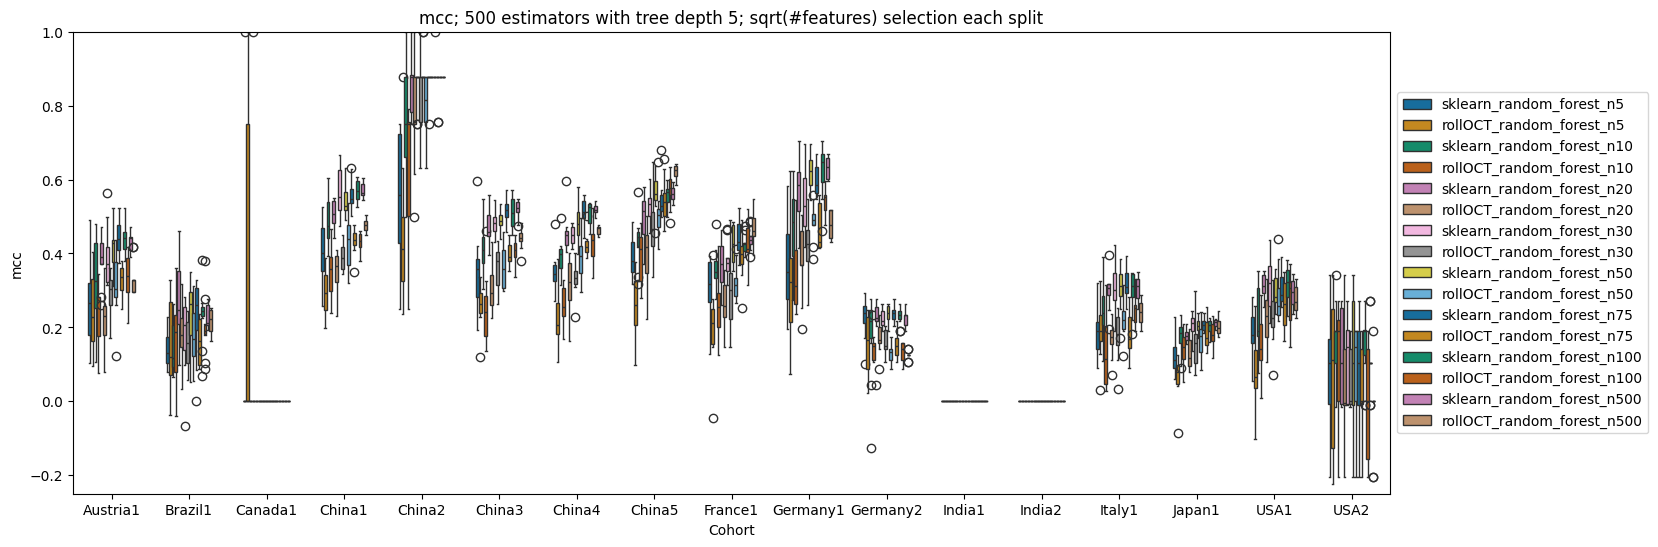

In [95]:
figure_mcc_seaborne_overview(list_cohorts = cohort_list, alias_dict = alias_dict, n_estimators_list = n_estimators_list, runs = 10, depth_tree = 5, subset_feat = 'sqrt')

In [96]:
#mcc_dict = mcc_dict_both_trees(list_cohorts = cohort_list, n_estimators_list = n_estimators_list, depth_tree = 5 , runs = 10, subset_feat = 'sqrt')
#print(mcc_dict)

In [97]:
def mcc_dict_both_trees(list_cohorts, n_estimators_list = [], depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    mcc_dict = dict() #entry contains list with #folds values
    
    for i, cohort in enumerate(list_cohorts):
        mcc_dict[cohort] = dict()
        for n_estimators in n_estimators_list:
            mcc_scores_rollOCT = get_mcc_list_rollOCT(cohort_name = cohort, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
            mcc_scores_sklearn = get_mcc_list_sklearn(cohort_name = cohort, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
            mcc_dict[cohort][f'rollOCT_random_forest_n{n_estimators}'] = mcc_scores_rollOCT
            mcc_dict[cohort][f'sklearn_random_forest_n{n_estimators}'] = mcc_scores_sklearn
    return mcc_dict

In [125]:
def figure_mcc_seaborne_each_cohort(list_cohorts, alias_dict = dict(), n_estimators_list = [], runs = 10, depth_tree = 5, subset_feat = 'sqrt'):
    if subset_feat == None:
        var_name = 'None'
    else:
        var_name = subset_feat
    mcc_dict = mcc_dict_both_trees(list_cohorts = list_cohorts, n_estimators_list = n_estimators_list, depth_tree = depth_tree , runs = runs, subset_feat = subset_feat)
    for cohort in list_cohorts:
        data = []
        for n_estimators in n_estimators_list:
                for mcc_type in [f'sklearn_random_forest_n{n_estimators}', f'rollOCT_random_forest_n{n_estimators}']:
                    label = 'sklearn_random_forest' if 'sklearn' in mcc_type else 'rollOCT_random_forest'
                    for value in mcc_dict[cohort][mcc_type]:
                        data.append({
                            'n_estimators': alias_dict.get(n_estimators, n_estimators),
                            'Type': label,
                            'mcc': value
                        })
        df = pd.DataFrame(data)
        df['n_estimators'] = df['n_estimators'].astype(str)


        fig = plt.figure(figsize=(5, 5))
        sns.boxplot(x='n_estimators', y='mcc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
        plt.ylim(-0.25, 1)
        plt.title(f"{cohort}; depth {depth_tree}; sqrt(#features) each split")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #fig.savefig(os.path.join('../microbiome_data/taxa_all_logo', f'boxplot_taxa_all_few_estimators_d{depth_tree}_{var_name}.png'))
        plt.show()

In [126]:
alias_dict_n_estimators = {
    5 : '5',
    10 : '10',
    20 : '20',
    30 : '30',
    50 : '50',
    75 : '75',
    100 : '100',
    500 : '500'    
}

/home/drood/Obsidian/Files/Bachelorarbeit/rlrf_my_try/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


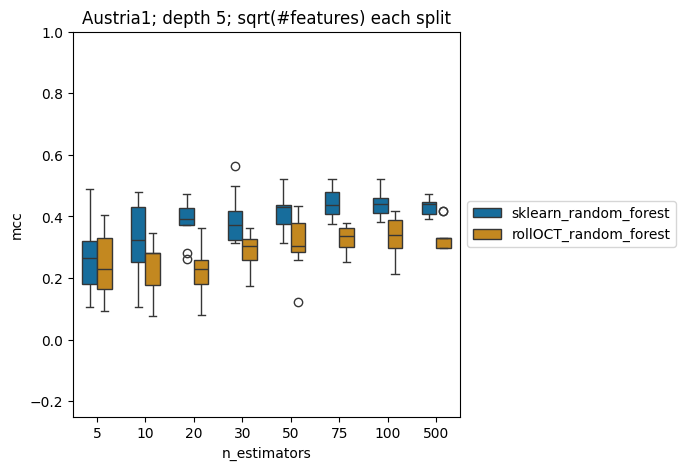

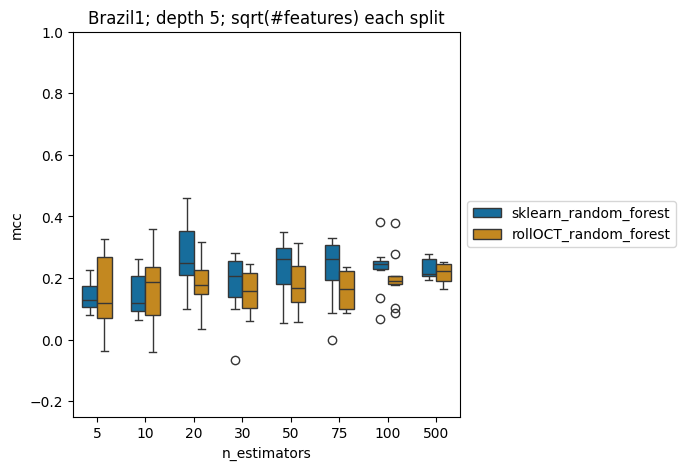

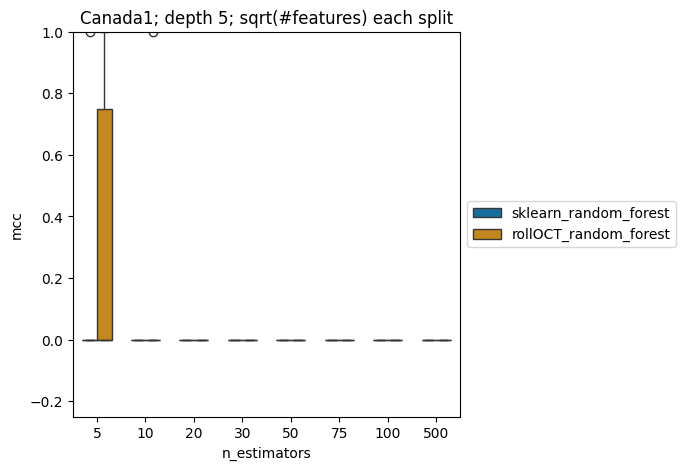

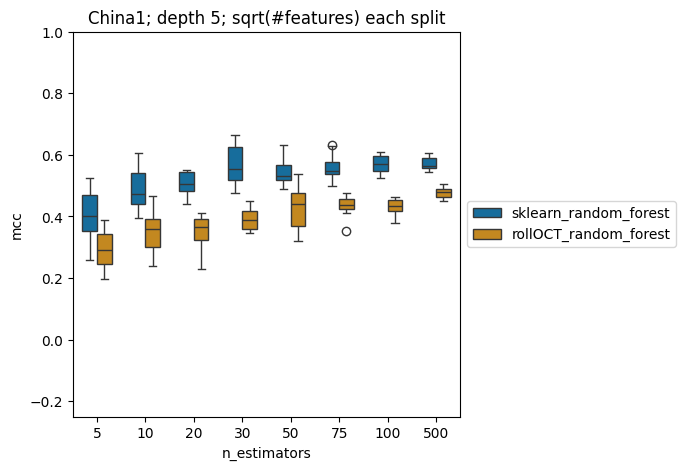

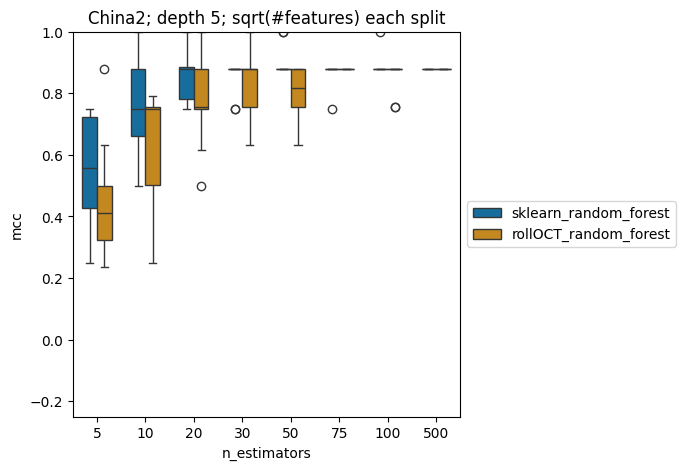

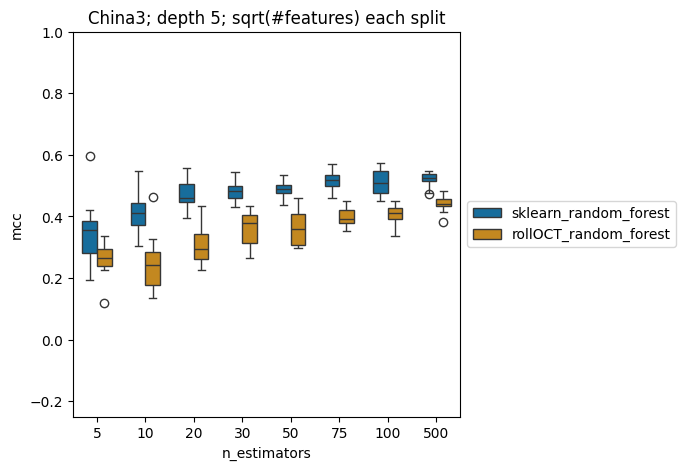

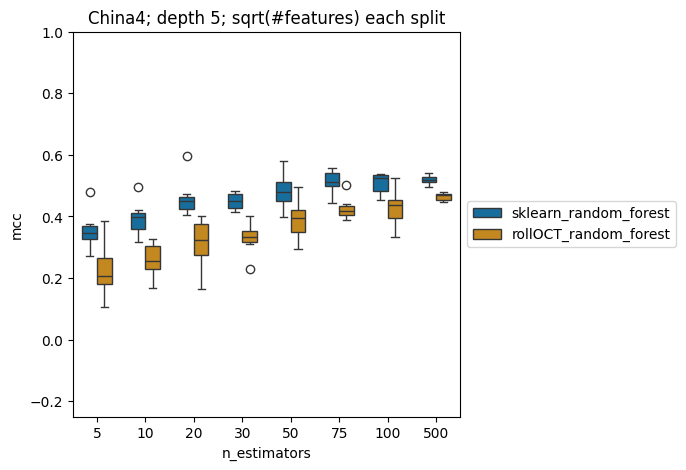

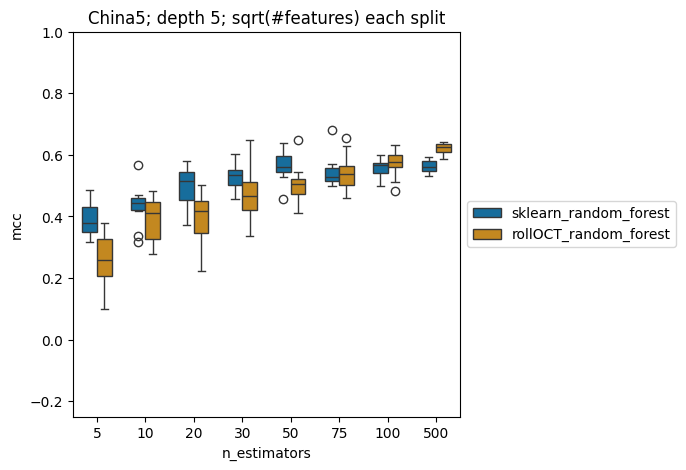

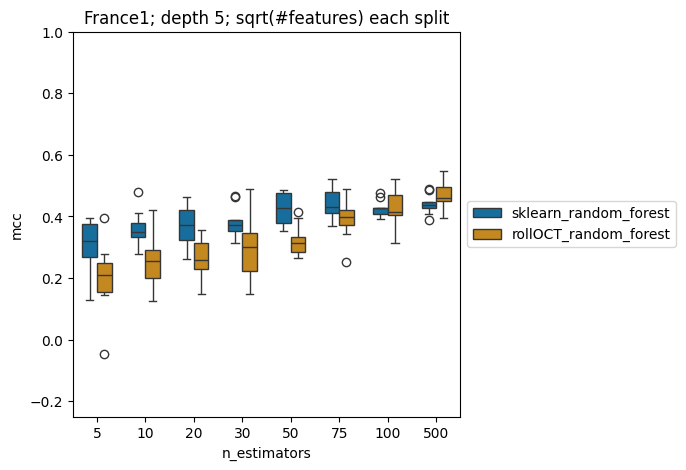

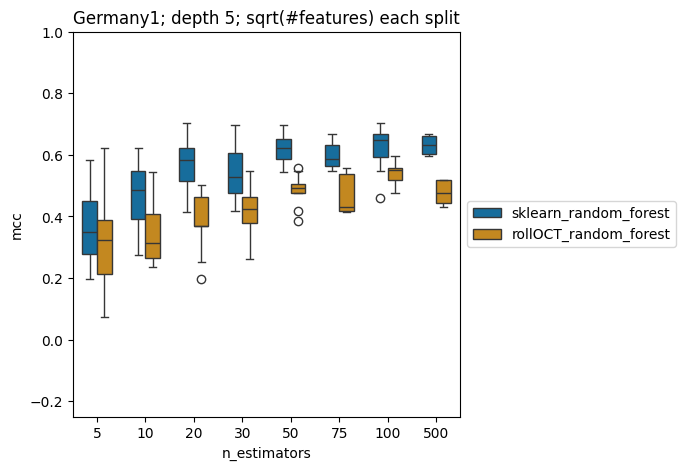

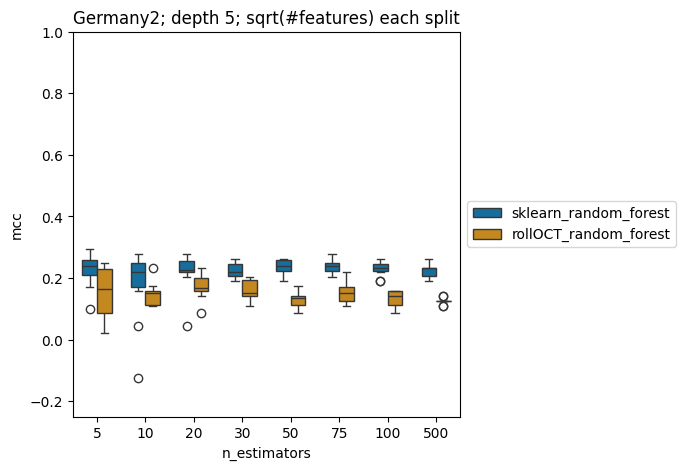

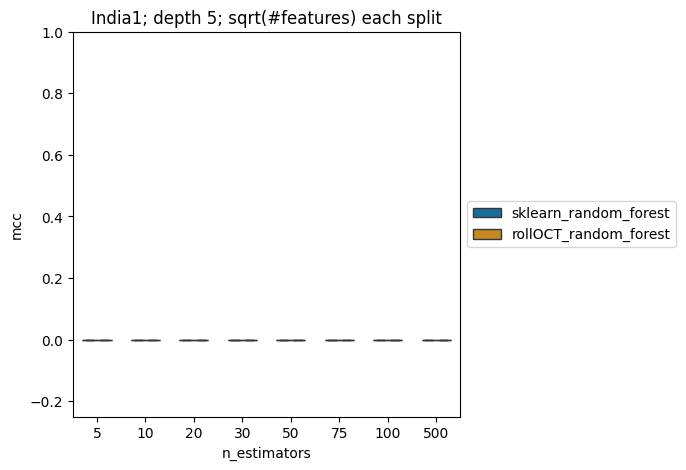

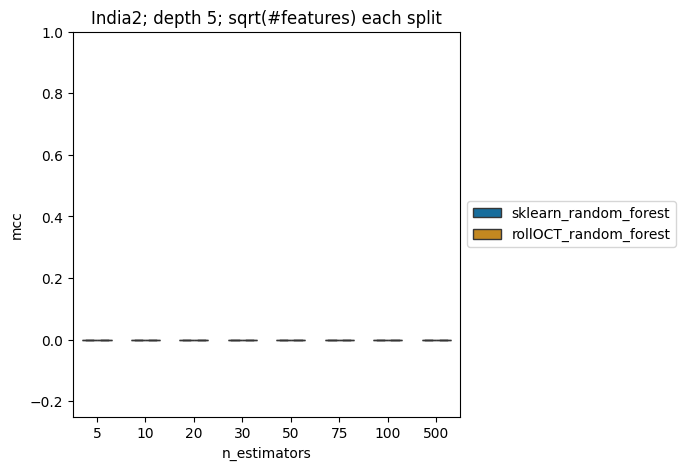

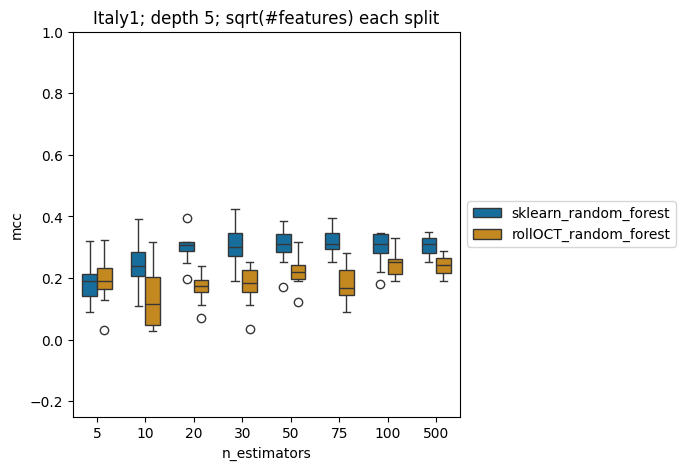

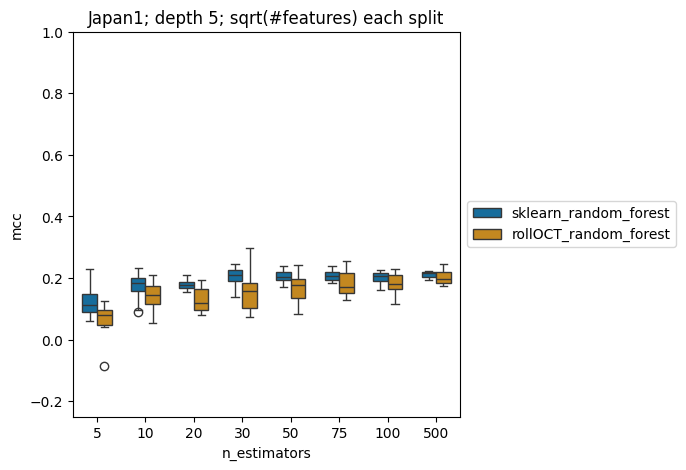

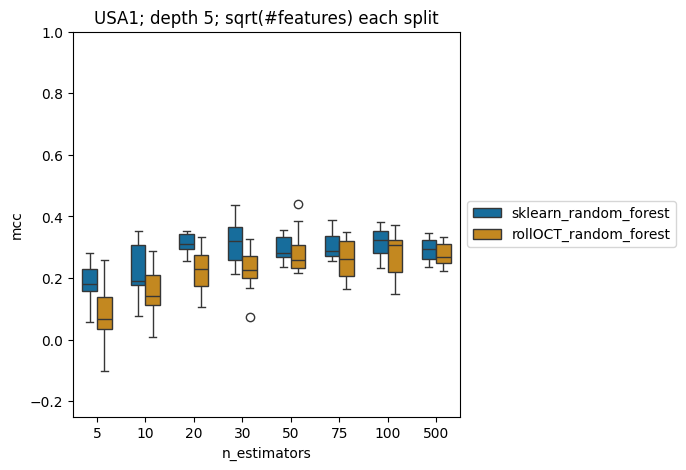

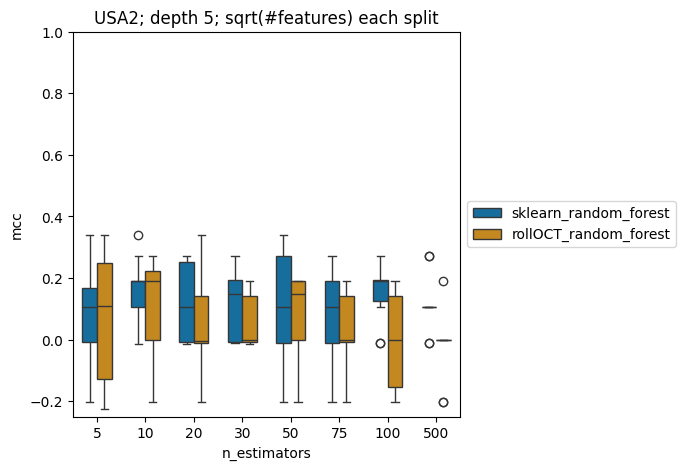

In [127]:
figure_mcc_seaborne_each_cohort(list_cohorts = cohort_list, n_estimators_list = n_estimators_list, runs = 10, depth_tree = 5, subset_feat = 'sqrt')

In [128]:
import math

def figure_mcc_seaborne_all_cohorts_grid(
    list_cohorts,
    alias_dict=dict(),
    n_estimators_list=[],
    runs=10,
    depth_tree=5,
    subset_feat='sqrt',
    cols=4  # Number of columns in the grid
):
    if subset_feat is None:
        var_name = 'None'
    else:
        var_name = subset_feat
    
    mcc_dict = mcc_dict_both_trees(
        list_cohorts=list_cohorts,
        n_estimators_list=n_estimators_list,
        depth_tree=depth_tree,
        runs=runs,
        subset_feat=subset_feat
    )
    
    rows = math.ceil(len(list_cohorts) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), constrained_layout=True, squeeze=False)
    
    for idx, cohort in enumerate(list_cohorts):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        
        data = []
        for n_estimators in n_estimators_list:
            for mcc_type in [f'sklearn_random_forest_n{n_estimators}', f'rollOCT_random_forest_n{n_estimators}']:
                label = 'sklearn_random_forest' if 'sklearn' in mcc_type else 'rollOCT_random_forest'
                for value in mcc_dict[cohort][mcc_type]:
                    data.append({
                        'n_estimators': alias_dict.get(n_estimators, n_estimators),
                        'Type': label,
                        'mcc': value
                    })
        
        df = pd.DataFrame(data)
        df['n_estimators'] = df['n_estimators'].astype(str)
        
        sns.boxplot(
            x='n_estimators',
            y='mcc',
            hue='Type',
            data=df,
            linewidth=1,
            width=0.6,
            dodge=True,
            palette='colorblind',
            ax=ax
        )
        
        ax.set_ylim(-0.25, 1)
        ax.set_title(f"{cohort}; depth {depth_tree}; sqrt(#features) each split")
        ax.legend_.remove()  # Remove individual legends
    
    # Put a single legend for the whole figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
    handles, labels,
    loc='upper center',  # Legend at top center
    bbox_to_anchor=(0.5, 1.05),  # Above the figure
    ncol=2,  # Number of columns in legend
    title='Forest Type'
    )
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    #plt.subplots_adjust(right=0.85, hspace=0.4)  # Give space for legend
    #fig.savefig(os.path.join('../microbiome_data/taxa_all_logo', f'boxplot_grid_taxa_all_few_estimators_d{depth_tree}_{var_name}.png'))
    plt.show()

/home/drood/Obsidian/Files/Bachelorarbeit/rlrf_my_try/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


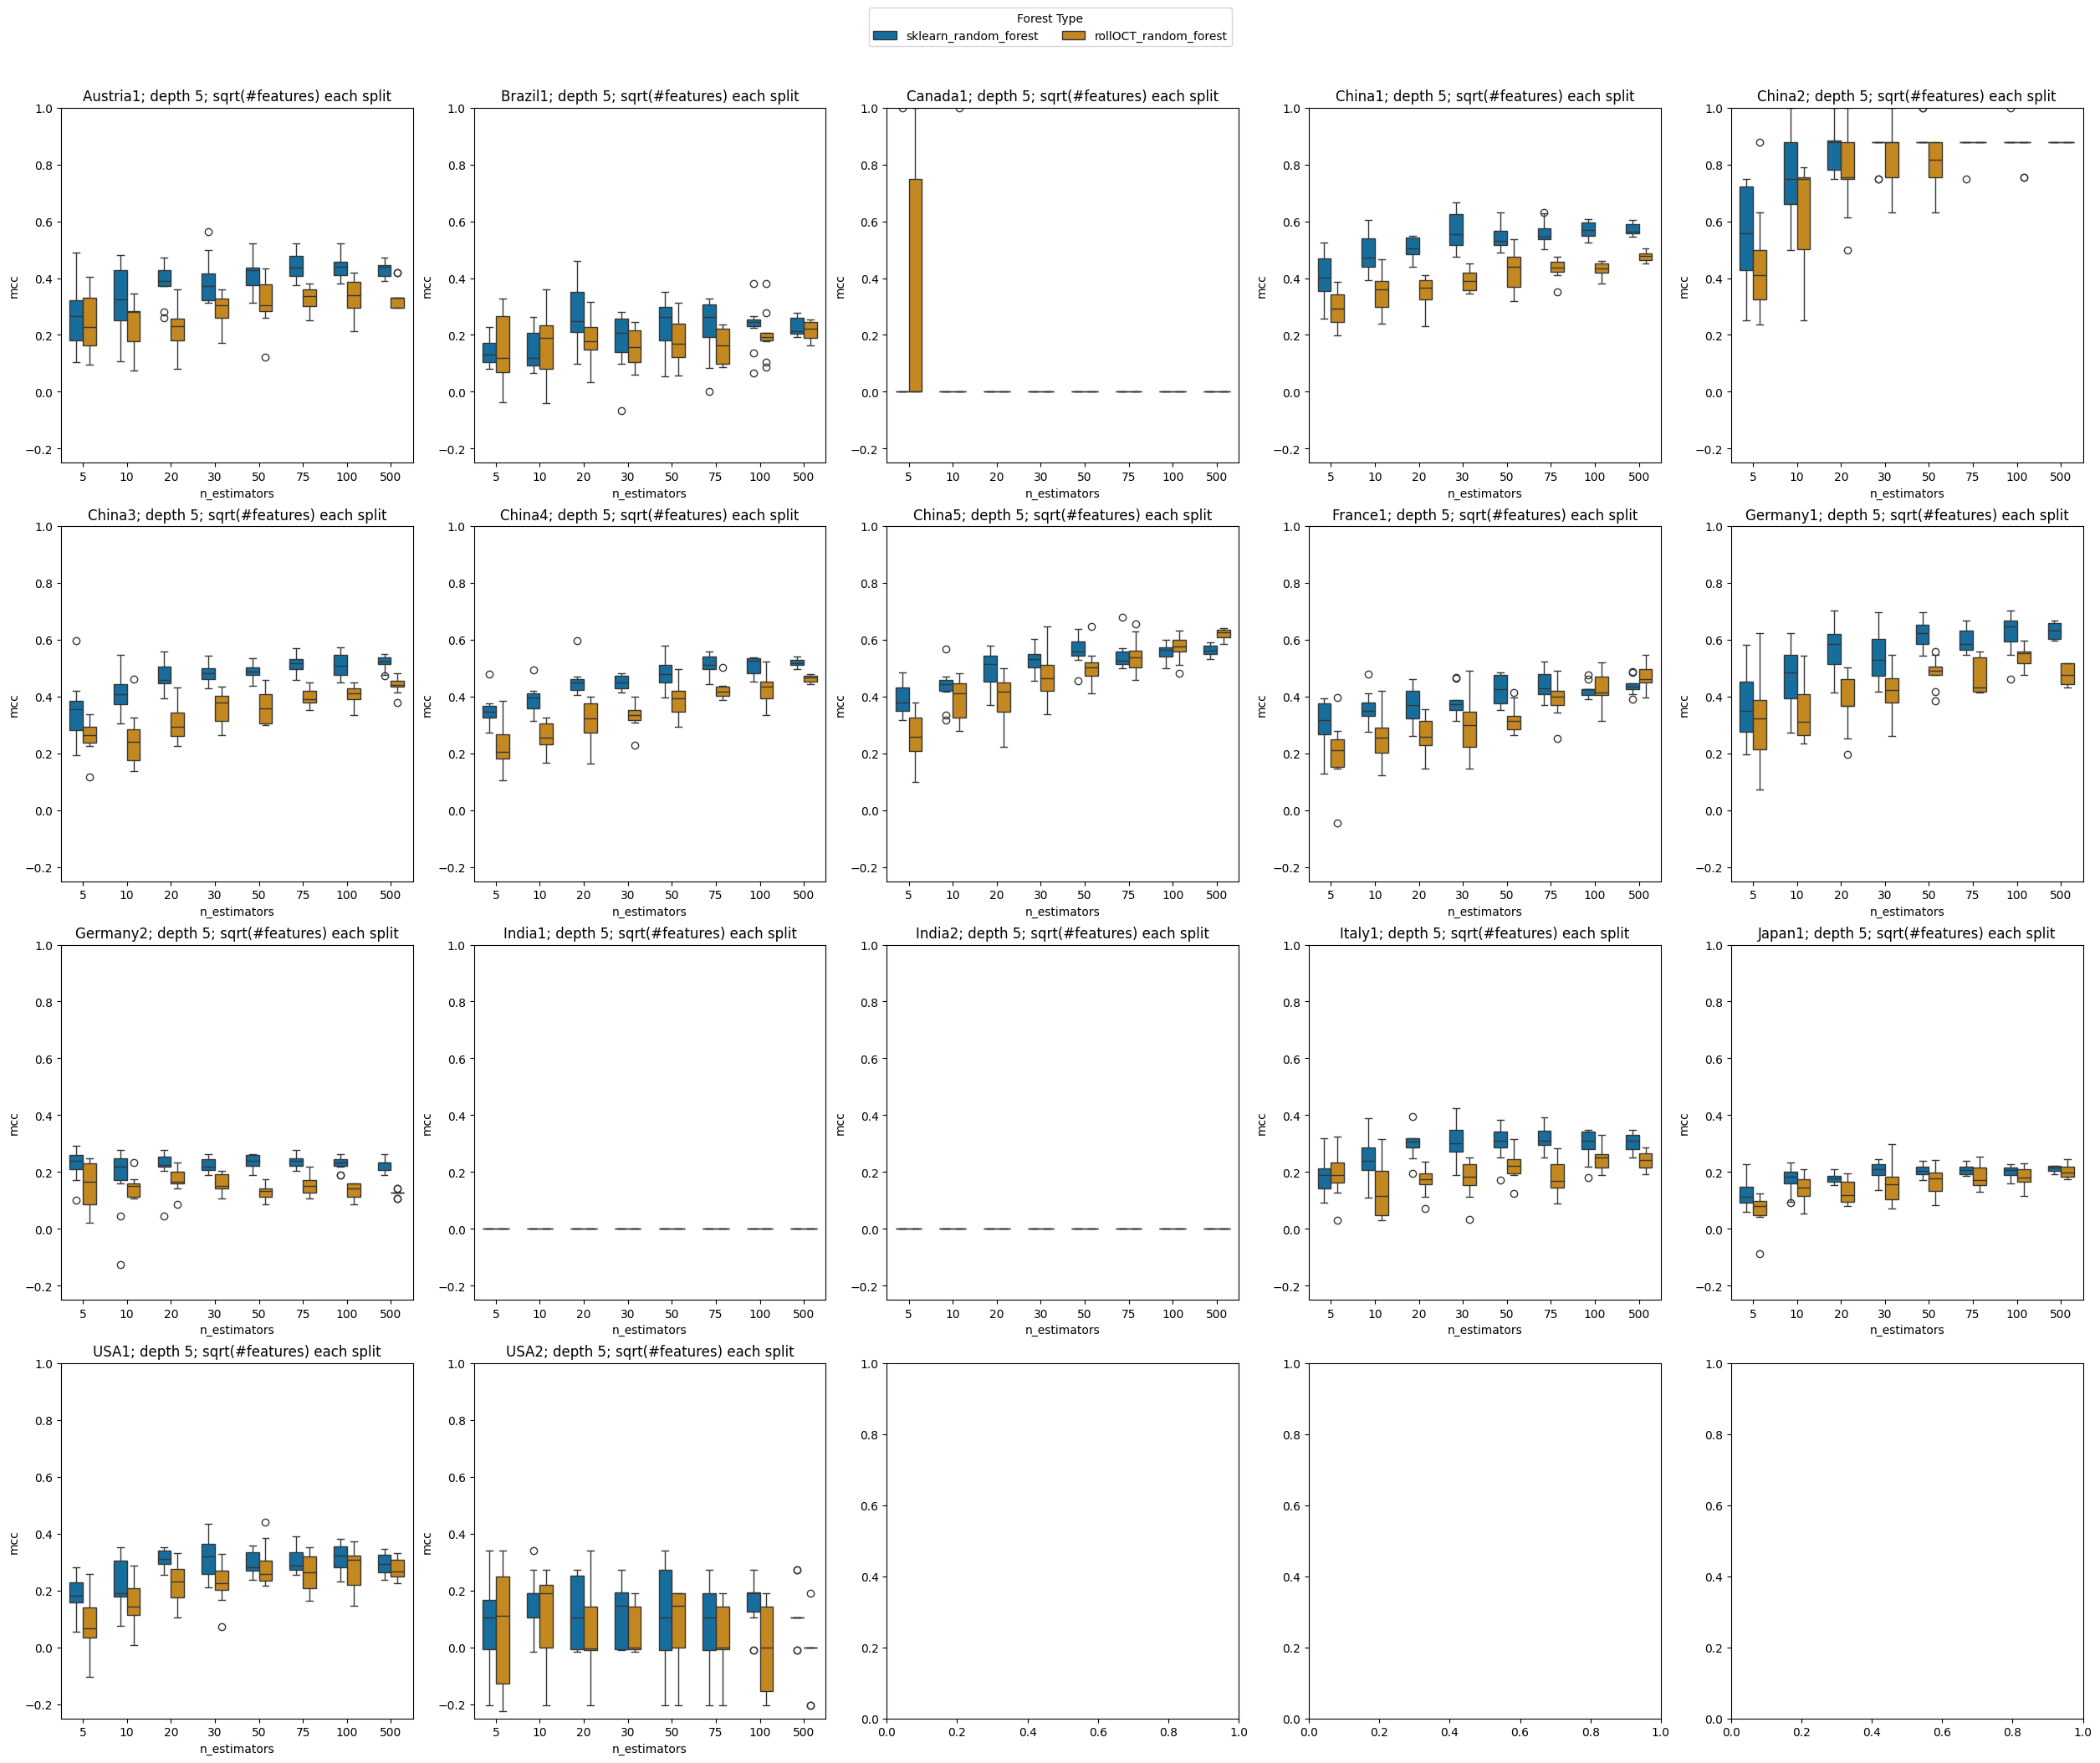

In [ ]:
figure_mcc_seaborne_all_cohorts_grid(
    list_cohorts=cohort_list,
    alias_dict=alias_dict_n_estimators,
    n_estimators_list=n_estimators_list,
    runs=10,
    depth_tree=5,
    subset_feat='sqrt',
    cols=4  # two plots per row, adjust as needed
)